## Get dataframe with images and labels

In [7]:
import pandas as pd
import numpy as np
import urllib
import sys
from tqdm import tqdm
sys.path.append('../taxonomy')
from streamlit_preparation import initialize, get_sample, queryFile
from utilities import normalize_title
from queryLabel import Taxonomy

## Using streamlit_preaparation
Not really working, getting error `RuntimeError: CUDA error: out of memory`

In [ ]:
files, taxonomy = initialize()
print(files.shape)
# files.head(10)

In [ ]:
n = 100_000
seed = int(args.seed) if args.seed else 0
files_sample = get_sample(n, seed)
tqdm.pandas()
files_sample[['labels', 'log']] = files_sample.progress_apply(lambda x: queryFile(x), 
                                                              axis=1, result_type="expand")

## As before
Use the naive approach from Francesco to get the labels from the categories of the 3.9M images from English articles in Wikipedia.

In [27]:
CATEGORIES_PATH = '/scratch/WikipediaImagesTaxonomy/commonswiki-20220220-category-network.parquet'
FILES_PATH = '/scratch/WikipediaImagesTaxonomy/commonswiki-20220220-files.parquet'
files = pd.read_parquet(FILES_PATH)
print(files.shape)
files.head()

(3891446, 4)


,id,title,url,categories
0,80902489,"""A Gathering of Court Women"", Folio from the D...",c/c1/%22A_Gathering_of_Court_Women%22%2C_Folio...,"[Department of Islamic Art, Metropolitan Museu..."
1,53631642,"""Akdeniz"" - Aliağa, 2016.jpg",f/f8/%22Akdeniz%22_-_Alia%C4%9Fa%2C_2016.jpg,"[Akdeniz (ship, 1955), Aliağa ship-breaking yard]"
2,74785910,"""Carnevale di Torino"". Felice Cerruti - f.lli ...",1/13/%22Carnevale_di_Torino%22._Felice_Cerruti...,"[Felice Cerruti Bauduc, Victor Emmanuel II of ..."
3,14890941,"""Escena de playa con figura"".jpg",c/c2/%22Escena_de_playa_con_figura%22.jpg,"[Pedro Lira, People with dogs in art]"
4,17828296,"""Florero con plátanos, limones y libros"", Juan...",d/da/%22Florero_con_pl%C3%A1tanos%2C_limones_y...,"[Works by Juan de Echevarría, Still-life paint..."


In [31]:
taxonomy = Taxonomy()
taxonomy.load_categories(CATEGORIES_PATH)
taxonomy.set_taxonomy(mapping='content_extended')

Loop through all images and get their labels with the naive approach, and remove duplicate labels within the same image.

In [32]:
files['new_labels'] = files['categories'].apply(lambda categories : [taxonomy.get_label(cat, how='naive') for cat in categories])
files['new_labels'] = files['new_labels'].apply(lambda labels : np.unique(np.array([element for items in labels for element in items])))

In [33]:
files.head()

,id,title,url,categories,new_labels
0,80902489,"""A Gathering of Court Women"", Folio from the D...",c/c1/%22A_Gathering_of_Court_Women%22%2C_Folio...,"[Department of Islamic Art, Metropolitan Museu...",[Culture]
1,53631642,"""Akdeniz"" - Aliağa, 2016.jpg",f/f8/%22Akdeniz%22_-_Alia%C4%9Fa%2C_2016.jpg,"[Akdeniz (ship, 1955), Aliağa ship-breaking yard]",[]
2,74785910,"""Carnevale di Torino"". Felice Cerruti - f.lli ...",1/13/%22Carnevale_di_Torino%22._Felice_Cerruti...,"[Felice Cerruti Bauduc, Victor Emmanuel II of ...","[Places, Society]"
3,14890941,"""Escena de playa con figura"".jpg",c/c2/%22Escena_de_playa_con_figura%22.jpg,"[Pedro Lira, People with dogs in art]","[Culture, Entertainment]"
4,17828296,"""Florero con plátanos, limones y libros"", Juan...",d/da/%22Florero_con_pl%C3%A1tanos%2C_limones_y...,"[Works by Juan de Echevarría, Still-life paint...",[]


In [34]:
non_empty_image_labels = files[files['new_labels'].str.len() != 0]
print(non_empty_image_labels.shape)
non_empty_image_labels.head()

(2008312, 5)


,id,title,url,categories,new_labels
0,80902489,"""A Gathering of Court Women"", Folio from the D...",c/c1/%22A_Gathering_of_Court_Women%22%2C_Folio...,"[Department of Islamic Art, Metropolitan Museu...",[Culture]
2,74785910,"""Carnevale di Torino"". Felice Cerruti - f.lli ...",1/13/%22Carnevale_di_Torino%22._Felice_Cerruti...,"[Felice Cerruti Bauduc, Victor Emmanuel II of ...","[Places, Society]"
3,14890941,"""Escena de playa con figura"".jpg",c/c2/%22Escena_de_playa_con_figura%22.jpg,"[Pedro Lira, People with dogs in art]","[Culture, Entertainment]"
6,17073242,"""Mary Holiday"" - NARA - 559051.jpg",0/02/%22Mary_Holiday%22_-_NARA_-_559051.jpg,"[Art of the United States, Harmon Foundation, ...","[Culture, History, Society]"
8,35274773,"""Reflections"" Porcelain Substrate Tile.jpg",f/f7/%22Reflections%22_Porcelain_Substrate_Til...,[Porcelain],[Places]


In [40]:
NAIVE_LABELS_PATH = 'data/commonswiki-20220220-files-naive-labels.json.bz2'
non_empty_image_labels.to_json(NAIVE_LABELS_PATH, compression='bz2')

#### Calculate distribution of labels through the images.

In [41]:
label_dict = {}

for index, row in tqdm(non_empty_image_labels.iterrows(), total=non_empty_image_labels.shape[0]):
    for label in row.new_labels:
        if label in label_dict:
            label_dict[label] += 1
        else:
            label_dict[label] = 1        

100%|██████████| 2008312/2008312 [02:05<00:00, 15940.22it/s]


Unique keys: 42


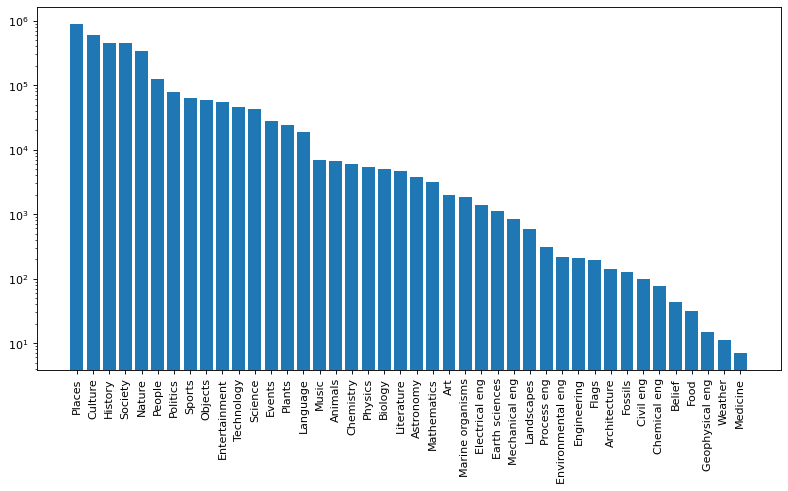

In [42]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(12, 6), dpi=80)
print(f'Unique keys: {len(label_dict.keys())}')

sorted_dict = dict(sorted(label_dict.items(), key=lambda item: item[1], reverse=True))

_ = plt.bar(range(len(sorted_dict)), list(sorted_dict.values()), align='center')
_ = plt.xticks(range(len(sorted_dict)), list(sorted_dict.keys()), rotation=90)
_ = plt.yscale('log')

In [47]:
non_empty_image_labels.reset_index(drop=True, inplace=True)
print(non_empty_image_labels.shape)
non_empty_image_labels.head()

(2008312, 5)


,id,title,url,categories,new_labels
0,80902489,"""A Gathering of Court Women"", Folio from the D...",c/c1/%22A_Gathering_of_Court_Women%22%2C_Folio...,"[Department of Islamic Art, Metropolitan Museu...",[Culture]
1,74785910,"""Carnevale di Torino"". Felice Cerruti - f.lli ...",1/13/%22Carnevale_di_Torino%22._Felice_Cerruti...,"[Felice Cerruti Bauduc, Victor Emmanuel II of ...","[Places, Society]"
2,14890941,"""Escena de playa con figura"".jpg",c/c2/%22Escena_de_playa_con_figura%22.jpg,"[Pedro Lira, People with dogs in art]","[Culture, Entertainment]"
3,17073242,"""Mary Holiday"" - NARA - 559051.jpg",0/02/%22Mary_Holiday%22_-_NARA_-_559051.jpg,"[Art of the United States, Harmon Foundation, ...","[Culture, History, Society]"
4,35274773,"""Reflections"" Porcelain Substrate Tile.jpg",f/f7/%22Reflections%22_Porcelain_Substrate_Til...,[Porcelain],[Places]


<ipython-input-61-7dbb79bdfa53>:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(random_indices.flatten()) / columns + 1, columns, i + 1)


FileNotFoundError: [Errno 2] No such file or directory: '/scratch/WIT_Dataset/images/e/ee/BozemanPass1884.JPG'

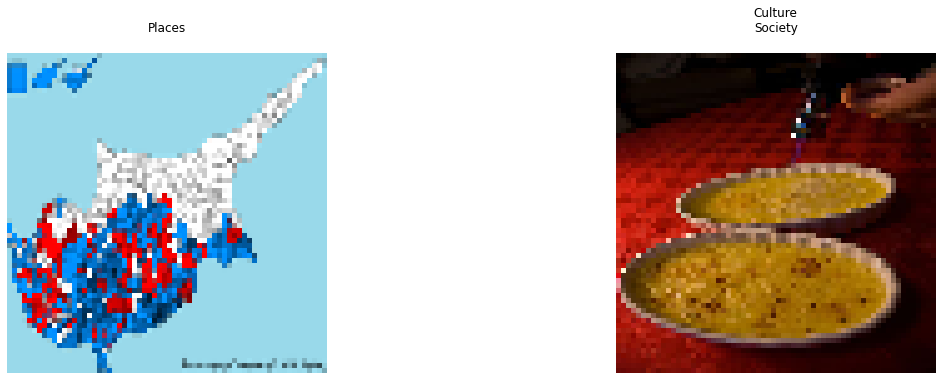

In [61]:
from tensorflow.keras.preprocessing.image import load_img

plt.figure(figsize=(20, 20))
IMAGE_DIMENSION = 64
columns = 2
rows = 2
random_indices = np.random.randint(low=0, high=1e5, size=(rows,columns))
for i, idx in enumerate(random_indices.flatten()):
    path = '/scratch/WIT_Dataset/images/' + non_empty_image_labels.iloc[idx, :].url
    img = load_img(path, target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION))
    plt.subplot(len(random_indices.flatten()) / columns + 1, columns, i + 1)
    plt.imshow(img)
    plt.axis('off')
    title = ''.join([label + '\n' for label in non_empty_image_labels.iloc[idx, :].new_labels])
    plt.title(title)
plt.suptitle('Some images and their ground truths')